In [1]:
import sys
sys.path.append('../')

In [2]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from utils.eval import score
from utils.models import CentroidSMOTE
from imblearn.over_sampling import SMOTE

# Reading, Preprocessing and EDA

In [3]:
train_df = pd.read_csv('../datasets/p53Mutant/p53_new_2012/Data Sets/K9.data',header = None, low_memory=False)

In [4]:
train_df.shape

(31420, 5410)

In [5]:
train_df.drop(columns={5409}, inplace=True)

In [6]:
print(train_df.isnull().sum().sum(), train_df.isna().sum().sum())

0 0


In [7]:
columns = train_df.columns

In [8]:
columns[-1]

5408

In [9]:
targets = train_df[5408]
print(len(targets))

31420


In [10]:
for col in train_df.columns:
    if(len(train_df[col].unique()) == 1):
        print(len(train_df[col].unique()))

In [11]:
missing_in_row = []
delete_row = []
for row in range(len(train_df)):
    temp = (train_df.loc[row] == '?').sum()
    missing_in_row.append(temp)
    if(temp>100):
        delete_row.append(row)
missing_in_row = pd.Series(missing_in_row, dtype = float)
print(missing_in_row.value_counts())

0.0       31159
5408.0      137
4826.0      124
Name: count, dtype: int64


In [12]:
missing_in_column = []
delete_column = []
for col in train_df.columns:
    temp = (train_df[col] == '?').sum()
    missing_in_column.append(temp)
    if(temp > 100):
        delete_column.append(col)
missing_in_column = pd.Series(missing_in_column, dtype = float)
print(missing_in_column.value_counts())    

261.0    4826
137.0     582
0.0         1
Name: count, dtype: int64


In [13]:
train_df.drop(delete_row, axis=0, inplace=True)

In [14]:
missing_in_column = []
for col in train_df.columns:
    missing_in_column.append((train_df[col] == '?').sum())
missing_in_column = pd.Series(missing_in_column, dtype = float)
print(missing_in_column.value_counts())    

0.0    5409
Name: count, dtype: int64


In [15]:
unique_val= []
for col in train_df.columns:
    unique_val.append(len(train_df[col].unique()))
print(pd.Series(unique_val).value_counts())

500     14
534     12
617     11
546     11
526     10
        ..
1917     1
135      1
171      1
1988     1
2        1
Name: count, Length: 2893, dtype: int64


In [16]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,5399,5400,5401,5402,5403,5404,5405,5406,5407,5408
0,-0.161,-0.014,0.002,-0.036,-0.033,-0.093,0.025,0.005,0.000,-0.015,...,0.006,0.013,0.021,0.02,0.016,-0.011,0.003,0.01,-0.007,inactive
1,-0.158,-0.002,-0.012,-0.025,-0.012,-0.106,0.013,0.005,0.000,-0.002,...,0.002,-0.008,0.007,0.015,-0.008,-0.011,-0.004,0.013,0.005,inactive
3,-0.169,-0.025,-0.010,-0.041,-0.045,-0.069,0.038,0.014,0.008,-0.014,...,0.019,0.01,0.025,0.025,0.021,-0.012,0.006,0.016,-0.018,inactive
4,-0.183,-0.051,-0.023,-0.077,-0.092,-0.015,0.071,0.027,0.020,-0.019,...,0.051,0.012,0.05,0.038,0.051,-0.015,0.017,0.027,-0.049,inactive
5,-0.154,0.005,-0.011,-0.013,-0.002,-0.115,0.005,0.002,-0.003,0.002,...,-0.011,0.012,0.009,0.003,-0.001,0.002,-0.006,0.009,0.013,inactive


In [17]:
train_df.reset_index()
# train_df.drop(columns = ['index'])

,index,0,1,2,3,4,5,6,7,8,...,5399,5400,5401,5402,5403,5404,5405,5406,5407,5408
0,0,-0.161,-0.014,0.002,-0.036,-0.033,-0.093,0.025,0.005,0.000,...,0.006,0.013,0.021,0.02,0.016,-0.011,0.003,0.01,-0.007,inactive
1,1,-0.158,-0.002,-0.012,-0.025,-0.012,-0.106,0.013,0.005,0.000,...,0.002,-0.008,0.007,0.015,-0.008,-0.011,-0.004,0.013,0.005,inactive
2,3,-0.169,-0.025,-0.010,-0.041,-0.045,-0.069,0.038,0.014,0.008,...,0.019,0.01,0.025,0.025,0.021,-0.012,0.006,0.016,-0.018,inactive
3,4,-0.183,-0.051,-0.023,-0.077,-0.092,-0.015,0.071,0.027,0.020,...,0.051,0.012,0.05,0.038,0.051,-0.015,0.017,0.027,-0.049,inactive
4,5,-0.154,0.005,-0.011,-0.013,-0.002,-0.115,0.005,0.002,-0.003,...,-0.011,0.012,0.009,0.003,-0.001,0.002,-0.006,0.009,0.013,inactive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31154,31415,-0.005,-0.023,0.018,-0.016,-0.045,0.053,0.021,0.003,0.004,...,0.006,0.032,-0.059,0.03,0.017,0.005,0.142,0.075,-0.03,inactive
31155,31416,0.001,0.008,-0.001,0.012,0.020,-0.020,-0.008,-0.004,-0.003,...,-0.01,0.002,-0.077,0.031,-0.042,0.034,0.188,0.077,0.021,inactive
31156,31417,0.002,0.013,-0.002,0.016,0.031,-0.026,-0.011,-0.005,-0.004,...,-0.012,-0.013,-0.065,0.002,-0.039,0.05,0.163,0.075,0.031,inactive
31157,31418,-0.002,-0.012,0.002,-0.018,-0.027,0.036,0.013,0.005,0.006,...,0.015,0.011,-0.041,0.015,0.005,0.055,0.2,0.103,0.018,inactive


In [18]:
train_df.shape

(31159, 5409)

In [19]:
train_df, test_df = train_test_split(train_df, train_size = 0.9, random_state = 42) 
y_train = train_df[5408]
y_test = test_df[5408]
X_train = train_df.drop(columns = [5408], axis = 0)
X_test = test_df.drop(columns = [5408], axis = 0)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [20]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [21]:
X_train = X_train.astype('float64')
y_train = y_train.astype('float64')
X_test = X_test.astype('float64')
y_test = y_test.astype('float64')

In [22]:
pipeline = Pipeline([
    ('classifier', KNeighborsClassifier())
])

parameters = {
    'classifier__n_neighbors' : [3, 5, 7, 9, 11],
}

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.996470
Error Rate: 0.003530166880616137
Precision: 0.998234
Recall: 0.576923
F1-score: 0.632449
Selectivity: 0.576923
Balanced Accuracy: 0.576923
Geometric Mean: 0.576923


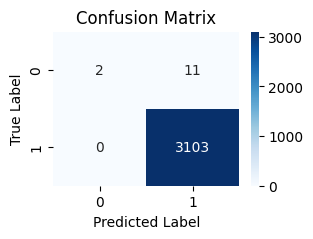

In [23]:
clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
best_clf = clf.fit(X_train, y_train)
score(X_test, y_test, best_clf)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.990051
Error Rate: 0.009948652118100143
Precision: 0.624351
Recall: 0.841803
F1-score: 0.681167
Selectivity: 0.841803
Balanced Accuracy: 0.841803
Geometric Mean: 0.841803


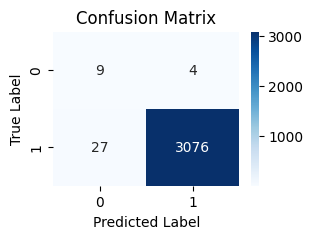

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.989730
Error Rate: 0.010269576379974277
Precision: 0.620972
Recall: 0.841642
F1-score: 0.677412
Selectivity: 0.841642
Balanced Accuracy: 0.841642
Geometric Mean: 0.841642


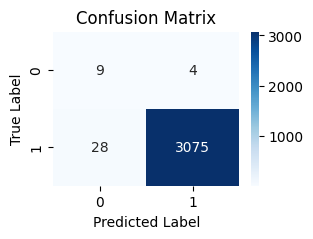

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.989409
Error Rate: 0.010590500641848521
Precision: 0.624512
Recall: 0.879781
F1-score: 0.686009
Selectivity: 0.879781
Balanced Accuracy: 0.879781
Geometric Mean: 0.879781


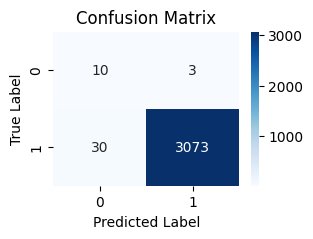

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.989089
Error Rate: 0.010911424903722766
Precision: 0.614735
Recall: 0.841320
F1-score: 0.670326
Selectivity: 0.841320
Balanced Accuracy: 0.841320
Geometric Mean: 0.841320


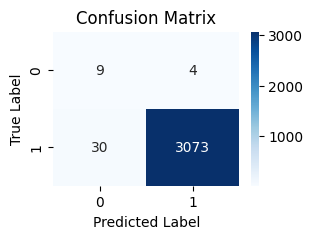

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.988447
Error Rate: 0.011553273427471145
Precision: 0.615791
Recall: 0.879298
F1-score: 0.675657
Selectivity: 0.879298
Balanced Accuracy: 0.879298
Geometric Mean: 0.879298


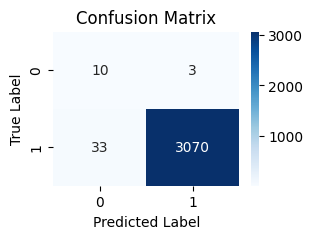

In [24]:
sm_list = []
for i in [3, 5, 7, 9, 11]:
    sm_list.append(SMOTE(random_state=42, k_neighbors=i))
for sm in sm_list:
    X_new, y_new = sm.fit_resample(X_train, y_train)
    pipeline = Pipeline([
        ('classifier', KNeighborsClassifier())
    ])

    parameters = {
        'classifier__n_neighbors' : [3, 5, 7, 9, 11],
    }

    clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
    best_clf = clf.fit(X_new, y_new)
    score(X_test, y_test, best_clf)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.991977
Error Rate: 0.008023106546854897
Precision: 0.633645
Recall: 0.766169
F1-score: 0.677469
Selectivity: 0.766169
Balanced Accuracy: 0.766169
Geometric Mean: 0.766169


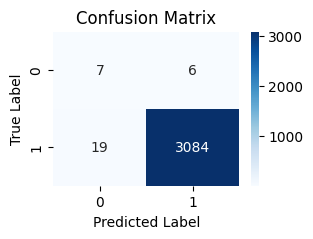

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.992298
Error Rate: 0.007702182284980763
Precision: 0.647339
Recall: 0.804631
F1-score: 0.698062
Selectivity: 0.804631
Balanced Accuracy: 0.804631
Geometric Mean: 0.804631


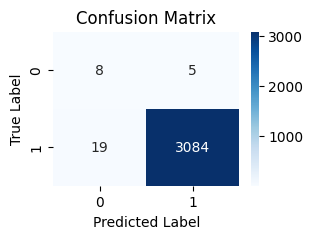

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.992298
Error Rate: 0.007702182284980763
Precision: 0.647339
Recall: 0.804631
F1-score: 0.698062
Selectivity: 0.804631
Balanced Accuracy: 0.804631
Geometric Mean: 0.804631


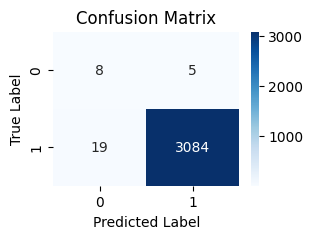

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.993261
Error Rate: 0.00673940949935814
Precision: 0.658121
Recall: 0.766814
F1-score: 0.698306
Selectivity: 0.766814
Balanced Accuracy: 0.766814
Geometric Mean: 0.766814


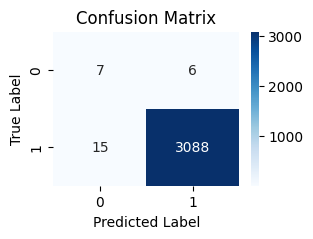

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.994865
Error Rate: 0.005134788189987138
Precision: 0.704914
Recall: 0.767619
F1-score: 0.732043
Selectivity: 0.767619
Balanced Accuracy: 0.767619
Geometric Mean: 0.767619


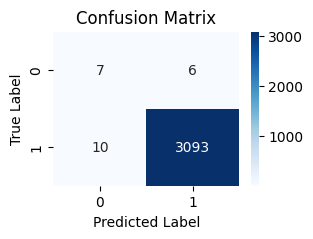

In [25]:
csm_list = []
for (i,j) in [(5,3), (7,3), (9,3), (7,5), (9,7)]:
    csm_list.append(CentroidSMOTE(k_neighbors=i, m_vertices=j))

for csm in csm_list:
    X_new, y_new = csm.fit_resample(X_train, y_train)
    pipeline = Pipeline([
        ('classifier', KNeighborsClassifier())
    ])

    parameters = {
        'classifier__n_neighbors' : [3, 5, 7, 9, 11],
    }

    clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
    best_clf = clf.fit(X_new, y_new)
    score(X_test, y_test, best_clf)